In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tqdm
import os
import time

/home/hs/anaconda3/envs/tf28/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RepVGGLayer(tf.keras.layers.Layer):
    def __init__(self, in_channel, out_channel, stride, padding, export=False):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.stride = stride
        self.padding = padding
        self.export = export

        if not self.export:
            self.zero_pad3x3 = tf.keras.layers.ZeroPadding2D(padding=self.padding)
            self.conv3x3 = tf.keras.layers.Conv2D(self.out_channel, 3, self.stride, padding='valid', use_bias=False)
            self.bn3x3 = tf.keras.layers.BatchNormalization()

            self.zero_pad1x1 = tf.keras.layers.ZeroPadding2D(padding=self.padding - 1)
            self.conv1x1 = tf.keras.layers.Conv2D(self.out_channel, 1, self.stride, padding='valid', use_bias=False)
            self.bn1x1 = tf.keras.layers.BatchNormalization()

            self.bnid = tf.keras.layers.BatchNormalization() if self.stride == 1 and self.in_channel == self.out_channel else None
        else:
            self.reparam_layer = tf.keras.Sequential([
                tf.keras.layers.ZeroPadding2D(padding=self.padding),
                tf.keras.layers.Conv2D(self.out_channel, 3, self.stride, padding='valid', use_bias=True)
                ])
 
        self.activation = tf.keras.layers.LeakyReLU()

    def call(self, input, training=False):
        if not self.export:
            input3x3 = self.zero_pad3x3(input)
            input1x1 = self.zero_pad1x1(input)
            id_out = 0 if self.bnid is None else self.bnid(input, training)
            x = self.bn3x3(self.conv3x3(input3x3), training) + self.bn1x1(self.conv1x1(input1x1), training) + id_out
        else:
            x = self.reparam_layer(input)
            
        x = self.activation(x)
        return x

    def get_reparam(self):
        kernel3x3, bias3x3 = self.reparam_branch(self.conv3x3, self.bn3x3)
        kernel1x1, bias1x1 = self.reparam_branch(self.conv1x1, self.bn1x1)
        kernelid, biasid = self.reparam_branch(None, self.bnid)
        return [kernel3x3 + self.pad_1x1_to_3x3(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid]
    
    def set_reparam(self, param):
        self.reparam_layer.layers[1].set_weights(param)

    def reparam_branch(self, conv, bn):
        if conv is None:
            if bn is None:
                return 0, 0
            kernel = np.zeros([3, 3, self.in_channel, self.in_channel], np.float32)
            for i in range(self.in_channel):
                kernel[1, 1, i, i] = 1
        else:
            kernel = conv.weights[0]

        std = tf.sqrt(bn.moving_variance + bn.epsilon)
    
        return kernel * bn.gamma / std, bn.beta - bn.moving_mean * bn.gamma / std

    def pad_1x1_to_3x3(self, kernel1x1):
        return tf.pad(kernel1x1, tf.constant([[1,1], [1,1], [0,0], [0,0]]))


In [3]:
class RepVGGBlock(tf.keras.layers.Layer):
    def __init__(self, in_channel, out_channel, stride, num_block, export=False):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.stride = stride
        self.num_block = num_block
        self.export = export

        self.rep_vgg_block = [RepVGGLayer(self.in_channel, self.out_channel, self.stride, 1, self.export)]

        for l in range(self.num_block-1):
            self.rep_vgg_block += [RepVGGLayer(self.out_channel, self.out_channel, 1, 1, self.export)]

    def call(self, input, training=False):
        x = input
        for l in range(self.num_block):
            x = self.rep_vgg_block[l](x, training)
        return x

    def get_reparam(self):
        param = []
        for l in range(self.num_block):
            param += [self.rep_vgg_block[l].get_reparam()]

        return param
    
    def set_reparam(self, param):
        for l in range(self.num_block):
            self.rep_vgg_block[l].set_reparam(param[l])

In [4]:
class RepVGG(tf.keras.Model):
    def __init__(self, num_blocks, num_classes, export=False):
        super().__init__()
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.export = export

        self.stage = [
            RepVGGBlock(1, 64, 2, self.num_blocks[0], self.export),
            RepVGGBlock(64, 64, 2, self.num_blocks[1], self.export),
            RepVGGBlock(64, 128, 2, self.num_blocks[2], self.export), 
            RepVGGBlock(128, 256, 2, self.num_blocks[3], self.export),
            RepVGGBlock(256, 512, 2, self.num_blocks[4], self.export)]
        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.linear = tf.keras.layers.Dense(self.num_classes)

    def call(self, input, training=False):
        x = input
        for l in range(len(self.stage)):
            x = self.stage[l](x, training)
        x = self.gap(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.linear(x)
        return x

    def get_reparam(self):
        param = []
        for l in range(len(self.stage)):
            param += [self.stage[l].get_reparam()]
        param += [self.linear.weights]
        return param
    
    def set_reparam(self, param):
        for l in range(len(self.stage)):
            self.stage[l].set_reparam(param[l])
        self.linear.set_weights(param[-1])
        

In [5]:
model = RepVGG([1, 2, 4, 14, 1], num_classes=10)

2023-07-23 21:41:43.952965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-23 21:41:43.968072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-23 21:41:43.968218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-23 21:41:43.968882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
epochs = 10
batch_size = 512

data, info = tfds.load('mnist', with_info=True, as_supervised=True, data_dir='./data')
train_data = data['train']
test_data = data['test']

train_data = train_data.batch(batch_size, drop_remainder=True, num_parallel_calls=-1).cache().shuffle(60000).prefetch(-1)
test_data = test_data.batch(batch_size, drop_remainder=True, num_parallel_calls=-1).cache().prefetch(-1)

train_dataset_length = info.splits['train'].num_examples // batch_size
test_dataset_length = info.splits['test'].num_examples // batch_size

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

max_loss = 1e+30

In [7]:
def train(model):
    for epoch in range(epochs):
        train_tqdm = tqdm.tqdm(train_data, total=train_dataset_length, desc=f'train epoch {epoch+1}/{epochs}', ascii=' =', colour='red')
        total_loss = 0
        for iter, batch_data in enumerate(train_tqdm):
            if iter >= 10:
                optimizer.lr.assign(1e-3)
            elif iter >= 70:
                optimizer.lr.assign(1e-4)
            x = tf.cast(batch_data[0], tf.float32)/255
            y = tf.cast(batch_data[1], tf.float32)
            with tf.GradientTape() as train_tape:
                preds = model(x, True)
                loss_ = loss(y, preds)
                gradients = train_tape.gradient(loss_, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_loss += loss_
            loss_ = total_loss / (iter+1)
            train_tqdm.set_postfix_str(f'lr={optimizer.lr.numpy():.4f}, loss={loss_.numpy():.5f}')
train(model)

train epoch 1/10:   0%|          | 0/117 [00:00<?, ?it/s]2023-07-23 21:41:45.532848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8900
2023-07-23 21:41:45.982132: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
train epoch 10/10: 100%|==========| 117/117 [00:09<00:00, 11.86it/s, lr=0.0010, loss=0.12220]


In [8]:
rep_model = RepVGG([1, 2, 4, 14, 1], num_classes=10, export=True)
rep_model.build((None, 28, 28, 1))
rep_model.set_reparam(model.get_reparam())

In [9]:
def test(model1, model2):
    correct = 0
    correct_re = 0
    total = batch_size * test_dataset_length
    total_time1 = 0
    total_time2 = 0
    error = 0

    test_tqdm = tqdm.tqdm(test_data, total=test_dataset_length, desc=f'test ', ascii=' =', colour='blue')
    for iter, batch_data in enumerate(test_tqdm):
        x = tf.cast(batch_data[0], tf.float32)/255
        y = batch_data[1]
        t1 = time.time()
        preds = model1(x)
        t2 = time.time()
        total_time1 += (t2-t1)
        preds_re = model2(x, False)
        t3 = time.time()
        total_time2 += (t3-t2)
        correct += tf.reduce_sum(tf.cast(y==tf.argmax(preds, -1), tf.int32))
        correct_re += tf.reduce_sum(tf.cast(y==tf.argmax(preds_re, -1), tf.int32))
        error += tf.reduce_sum(tf.abs(preds - preds_re))
        test_tqdm.set_postfix_str(f'[origin| correct: {correct}/{total}, time: {t2-t1:.3f}/{total_time1:.3f}] [reparam| correct: {correct_re}/{total}, time: {t3-t2:.3f}/{total_time2:.3f}] [error| {error}]')
test(model, rep_model)

test : 100%|==========| 19/19 [00:00<00:00, 21.63it/s, [origin| correct: 9131/9728, time: 0.028/0.555] [reparam| correct: 9131/9728, time: 0.014/0.265] [error| 311.4334716796875]] 


In [10]:
x = tf.random.uniform((batch_size, 28, 28, 1))
y = model(x)
rep_y = rep_model(x)
print(tf.reduce_mean(tf.math.square(y - rep_y)))

tf.Tensor(1.9824403e-05, shape=(), dtype=float32)


In [11]:
sample_x, sample_y = next(iter(test_data))
output = None
row = None

In [12]:
for i, (x, y) in enumerate(zip(sample_x[:9], sample_y[:9])):
    x = tf.cast(x, tf.float32)/255
    pred = np.argmax(model(x[None]), -1)[0]
    rep_pred = np.argmax(rep_model(x[None]), -1)[0]
    x = cv2.cvtColor(cv2.resize(x.numpy(), [112, 112]), cv2.COLOR_GRAY2RGB)
    x = cv2.putText(x, str(pred), (0,20), cv2.FONT_HERSHEY_COMPLEX, 0.8, (1, 0, 0), 2)
    x = cv2.putText(x, str(rep_pred), (92,20), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 1), 2)
    if row is None:
        row = x
    else:
        row = np.concatenate([row, x], 1)
        if i%3 == 2:
            if output is None:
                output = row
            else:
                # print(output.shape, row.shape)
                output = np.concatenate([output, row], 0)
            row = None
    

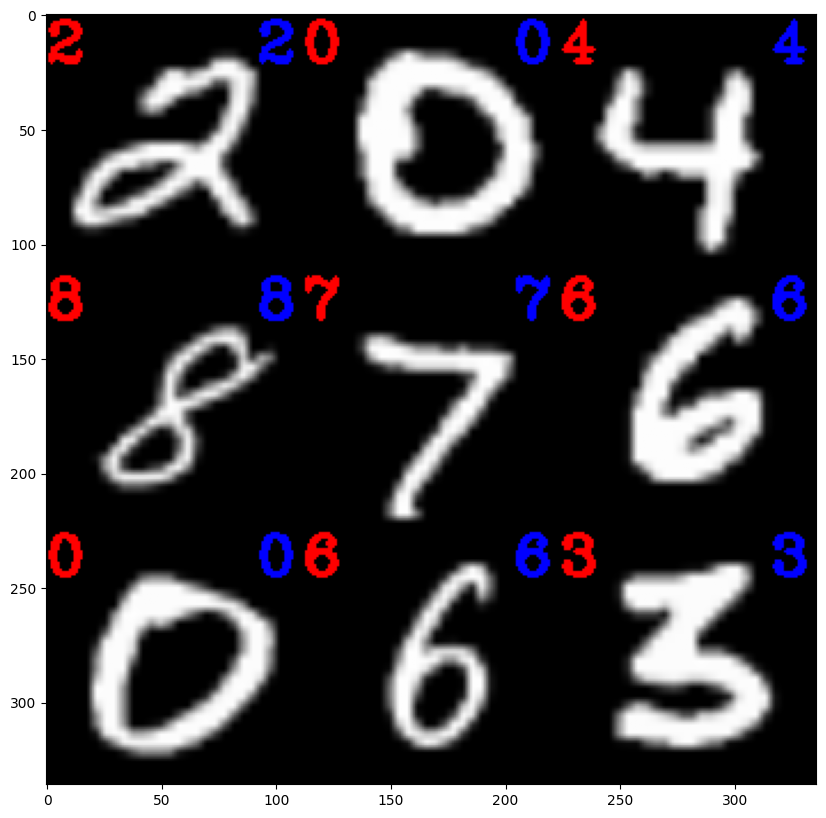

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()